In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from DEEPKNN_RESNET50 import Bottleneck, ResNet, ResNet50

from transform_data import trans_data

from deepknn_loss_func import DeepKNNLoss
#from RESNET50 import Bottleneck, ResNet, ResNet50

In [2]:
import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [3]:
EPOC=20
LR=0.001

In [4]:
train_data_path = r"C:\Users\joaog\Deep_Learning\Dataset\chest_xray\train"
test_data_path = r"C:\Users\joaog\Deep_Learning\Dataset\chest_xray\test"
trainloader,testloader = trans_data(train_data_path,test_data_path)

In [5]:
net = ResNet50(10).to('cuda')

criterion = DeepKNNLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [6]:
from tqdm import tqdm # Recommended for better progress bars
import time
start_time = time.time()
# --- 3. The Adapted Training Loop ---
EPOCHS = EPOC # Starting with fewer epochs for demonstration
for epoch in range(EPOCHS):
    net.train() # Set model to training mode
    
    running_loss = 0.0
    # Use tqdm for a nice progress bar
    for i, (inputs, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer.zero_grad()
        
        # 1. Get embeddings for the entire batch
        embeddings = net(inputs)
        # The output of our net is [batch_size, 2048, 1, 1], so we flatten it
        embeddings = embeddings.flatten(start_dim=1)

        # 2. Triplet Mining: Find anchor, positive, and negative samples
        # This is a simple but effective "in-batch" mining strategy
        anchors, positives, negatives = [], [], []
        for j in range(len(labels)):
            anchor_label = labels[j]
            anchor_embedding = embeddings[j]
            
            # Find indices of positive and negative samples in the batch
            positive_indices = (labels == anchor_label) & (torch.arange(len(labels)).cuda() != j)
            negative_indices = (labels != anchor_label)
            
            # If we have at least one positive and one negative...
            if torch.any(positive_indices) and torch.any(negative_indices):
                # Select one positive and one negative
                positive_idx = torch.where(positive_indices)[0][0]
                negative_idx = torch.where(negative_indices)[0][0]
                
                anchors.append(anchor_embedding)
                positives.append(embeddings[positive_idx])
                negatives.append(embeddings[negative_idx])
        
        # 3. If we found any valid triplets, calculate the loss
        if len(anchors) > 0:
            # Convert lists to tensors
            anchor_tensor = torch.stack(anchors)
            positive_tensor = torch.stack(positives)
            negative_tensor = torch.stack(negatives)
            
            # Calculate the triplet loss
            loss = criterion(anchor_tensor, positive_tensor, negative_tensor)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

    # Calculate and print average loss for the epoch
    avg_loss = running_loss / (i + 1)
    print(f"\nEnd of Epoch {epoch+1}, Average Triplet Loss: {avg_loss:.4f}")
    
    # Step the scheduler
    scheduler.step(avg_loss)

print('Training Done')
end_time = time.time()

Epoch 1/20: 100%|██████████| 20/20 [00:37<00:00,  1.88s/it]



End of Epoch 1, Average Triplet Loss: 0.2178


Epoch 2/20: 100%|██████████| 20/20 [00:38<00:00,  1.90s/it]



End of Epoch 2, Average Triplet Loss: 0.2715


Epoch 3/20:   0%|          | 0/20 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
elapsed_time = end_time - start_time

print(round(elapsed_time/60,2))

5.4


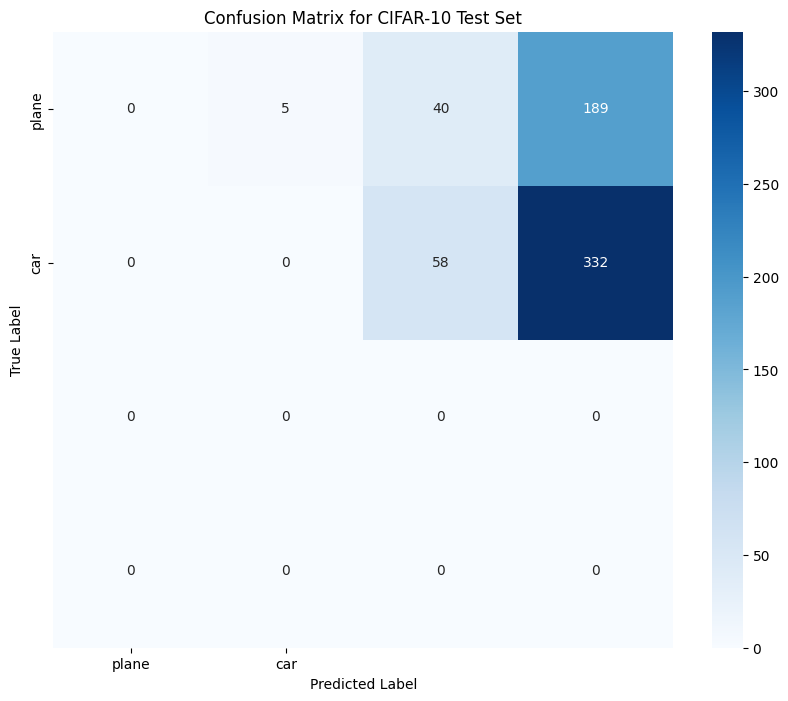

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- Ensure your network is in evaluation mode ---
net.eval()

# --- Lists to store true labels and predictions ---
all_labels = []
all_predictions = []

# --- No gradient calculation needed for inference ---
with torch.no_grad():
    # Iterate over the test data
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Get model outputs
        outputs = net(inputs)
        
        # Get the predicted class (the one with the highest score)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append batch predictions and labels to the lists
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Get the class names from the dataset ---
class_names = ['plane', 'car']

# --- Compute the confusion matrix ---
cm = confusion_matrix(all_labels, all_predictions)

# --- Plot the confusion matrix using seaborn ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CIFAR-10 Test Set')
plt.show()
